# Demo: analysing soil moisture data from the Climate Data Store in xcube

First, we import some necessary libraries and configure some matplotlib display preferences.

In [1]:
# xcube_cds imports
from xcube_cds.store import CDSDataStore

# xcube imports
import xcube
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry
from xcube.core.dsio import open_cube

# Various utilities
import json
import xarray as xr
import shapely.geometry
import IPython.display
import time
import zarr
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pathlib

# Plot settings
%matplotlib inline
plt.rcParams["figure.figsize"] = 16,12

Create a CDS data store object. The optional `normalize_names` parameter specifies that variable names in returned data cubes will be converted to legal Python identifiers, if required.

In [2]:
cds_store = CDSDataStore(normalize_names=True)

From the data store we request monthly averages of global volumetric soil moisture data from January 2015 to January 2016.

In [3]:
generated_cube = cds_store.open_data(
    'satellite-sea-ice-thickness:envisat',
    time_range=['2005-10-01', '2006-05-31']
)
cube = generated_cube

xcube-cds version 0.9.2.dev0
2022-05-02 12:38:16,275 INFO Welcome to the CDS
2022-05-02 12:38:16,276 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-ice-thickness
2022-05-02 12:38:16,414 INFO Request is completed
2022-05-02 12:38:16,415 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data6/dataset-satellite-sea-ice-thickness-2c18395c-4ade-4b85-95a6-f446057d9a17.tar.gz to /tmp/tmp5oxf3cl0/tmp7p66a1r_/data (29.5M)
2022-05-02 12:38:17,967 INFO Download rate 19M/s                                


Plot the bounding box on a map to check that the cube covers the expected area.

In [4]:
bbox = [float(cube.geospatial_lon_min), float(cube.geospatial_lat_min), float(cube.geospatial_lon_max), float(cube.geospatial_lat_max)]
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Plot the differences between successive time points in the dataset. We can see that the times are monotonically increasing (all the difference values are positive), but not equally spaced, since months are not all of the same length. The lowest values correspond to February; the four-year leap year cycle can also be discerned.

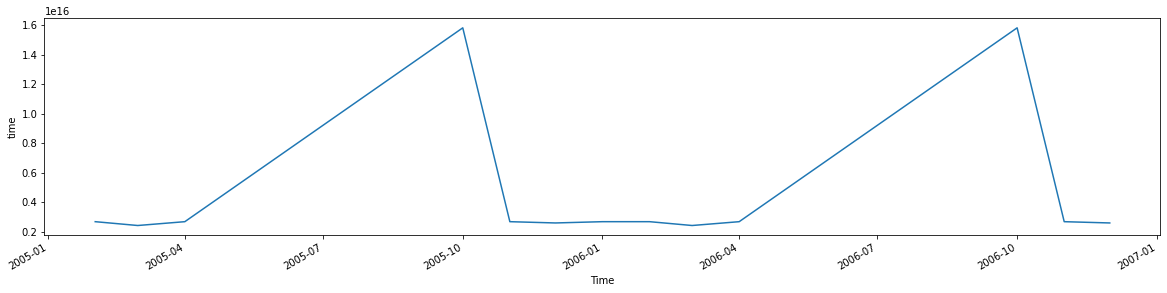

In [5]:
cube.time.diff(dim='time').plot.line(figsize=(20, 4))

As a quick initial test, we plot a simple plate carrée projection (with longitude and latitude mapped directly to the x and y co-ordinates respectively) for the first time-point available.

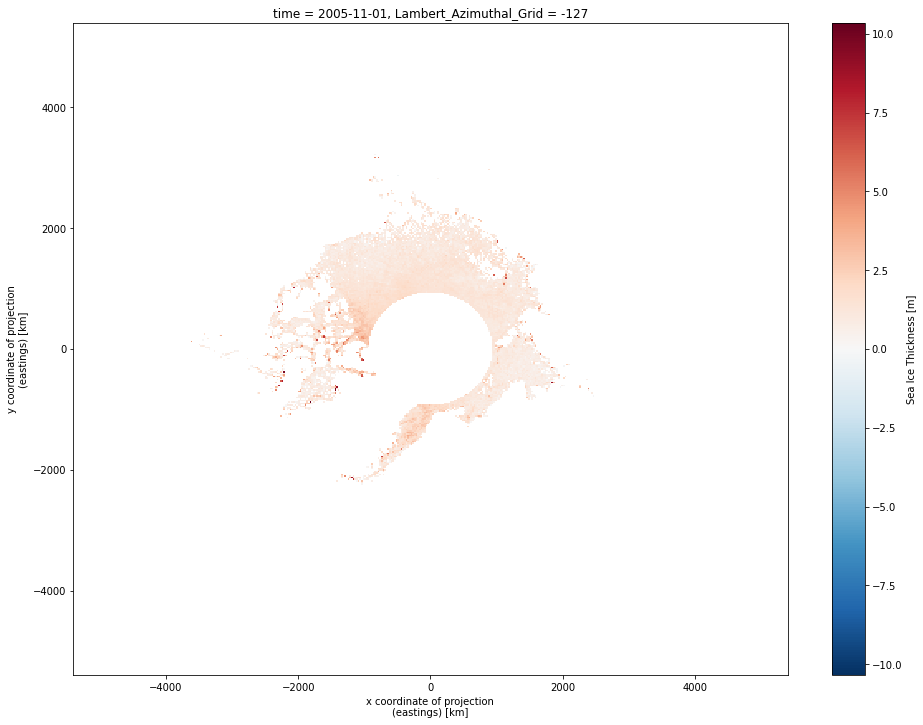

In [6]:
sit_2005_nov = cube.sea_ice_thickness.sel(time='2005-11-01 00:00:00', method='nearest')
sit_2005_nov.plot.imshow()

Now we define a plotting function which restricts the plotted area to Europe.

In [7]:
def plot_map(data_array, colour_scale=(None, None), cmap=None):
    data_array[125:300, 125:300].plot.imshow(vmin=colour_scale[0], vmax=colour_scale[1], figsize=(14,12), cmap=cmap)

common_scale = (260, 300)

First we plot the soil moisture for January 2015. We use an inverted version of the matplotlib ‘viridis’ colour map ranging from yellow (least moisture) to dark blue (most moisture). 

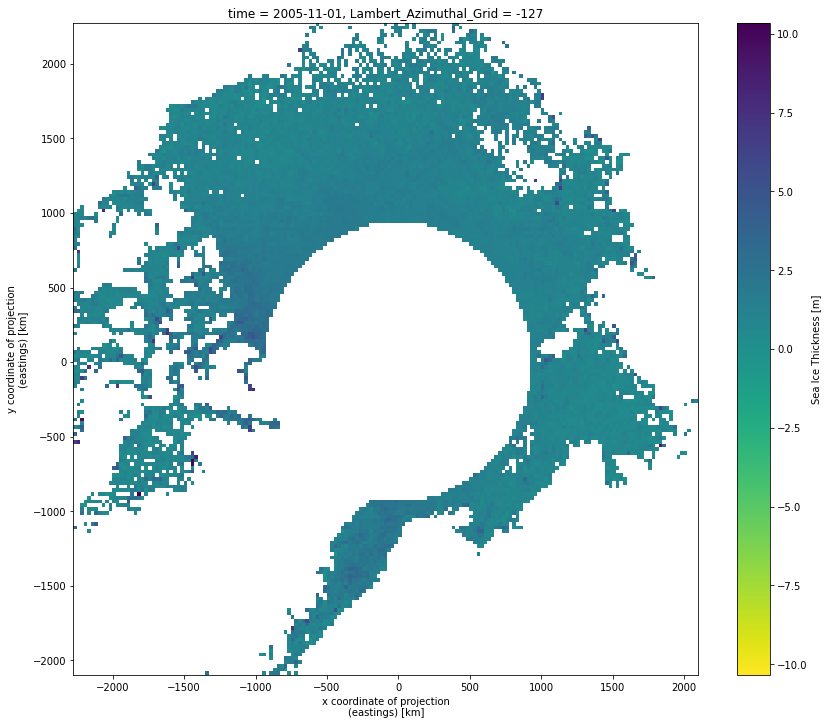

In [8]:
plot_map(sit_2005_nov, cmap='viridis_r')

For comparison, we plot the data for July 2015. Note the overall lower moisture levels (particularly in southern regions) and the improved coverage at higher altitudes and latitudes (probably due to less snow and ice cover).

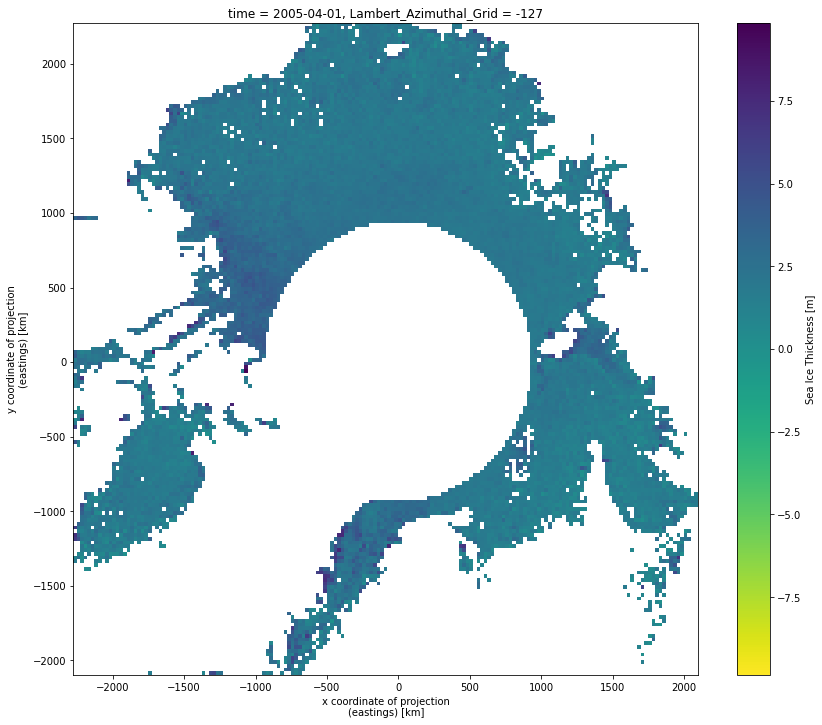

In [9]:
sit_2006_may = cube.sea_ice_thickness.sel(time='2005-05-15 00:00:00', method='nearest')
plot_map(sit_2006_may, cmap='viridis_r')

By subtracting the January data from the July data, we can see more clearly where the soil moisture decreases the most in the summer.

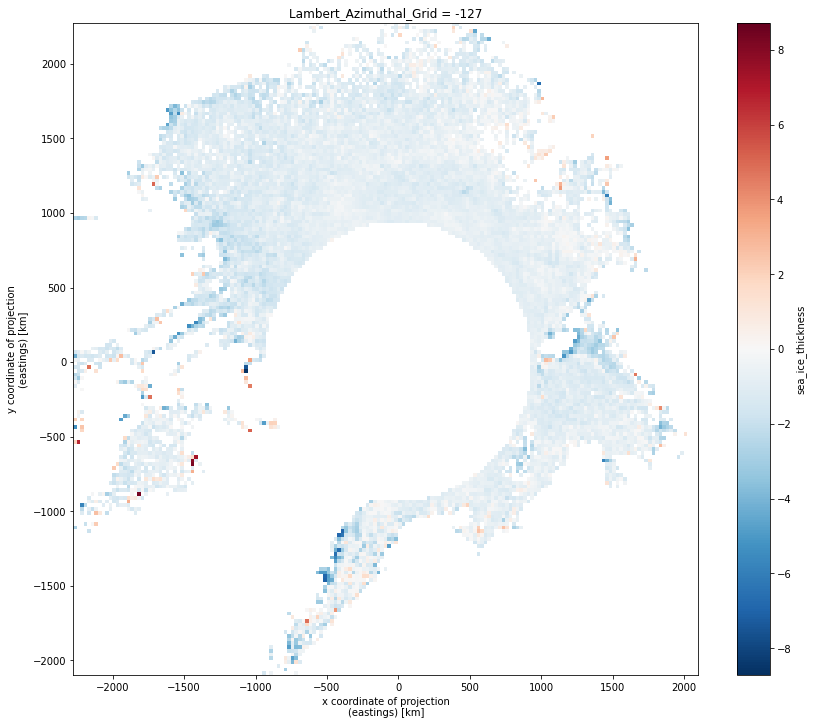

In [10]:
plot_map(sit_2005_nov - sit_2006_may)